# Multilayer perceptron
In this notebook we will implement a multilayer perceptron (MLP) with only one single hidden layer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

numpy version: 1.23.1
pandas version: 1.4.3


## The MNIST data set
The MNIST data set is a collection of 70000 28x28 pixels images representing the digits from 0 to 9. the data set is composed of a matrix of 70000 rows, one for each image, and 784 columns that represent the pixel values. The labels are represented in an array of 70000 rows and each value represents the class of that image, that is the digit of the corresponding image.  

In [2]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [42]:
X_std = ((X / X.max()) - .5) * 2
X_std.min(), X_std.max()

(-1.0, 1.0)

We plot a sample of the 10 digits

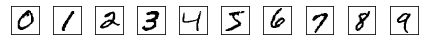

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_std[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

And ten examples of handwritten digit 7

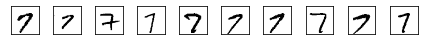

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_std[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Data partition

In [43]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(X_std, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## The multilayer perceptron model
We define a MLP class that implements three functions: an init() function to initialize the matrix that will contain the weights of the hidden layer, a forward() function to compute the digit class from an input image, and a backward() function to compute the derivatives of the cost function that are used to update the weights with the backpropagation algorithm. 

We implement the activation function (sigmoid) and a function of the one-hot encoding of the labels.

In [17]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

The functions init(), forward() and backward() definitions are similar to the functions defined in PyTorch for a neural network. The size of the weight matrix that represent the connection between the units of the input layer and the units of the hidden layer is (number of features)x(number of units in the hidden layer), in our case 784x50. The size of the 2nd matrix that connects the output of the hidden layer and the output layer is (number of units in the hidden layer)x(number of classes), in our case 50x10.

In [19]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

## The training loop
Once we have defined our model and implemented the functions to define the structure of the network, the forward function and the backpropagation algorithm to update the weights in order to minimize the loss, we can instantiate our neural network model and start the training process.

In [20]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [37]:
indices.shape[0]

70000

### The data loading
We define a function that creates the mini batches that will be used as input to the network during the training process. Each batch will be used to update the weights as in the stochastic gradient descent (SGD) algorithm used for the backward propagation. The difference between gradient descent and SGD is that with gradient descent the weight are updated using all the training at every epoch while with SGD the weights are updated using a small subset, called the minibatch. 

In [38]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

We split the data set into minibatches of 100 images

In [44]:
num_epochs = 50
minibatch_size = 100

# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


### The performance metric
We define the performance metric to monitor the training process and update the weights accordingly. The loss fumction is the mean squared error (MSE loss)

In [45]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [46]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [47]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc